# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [143]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)




## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [144]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [145]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [146]:
# flatten the labels
y_train_flat = y_train.flatten()
label_counts = pd.Series(y_train_flat).value_counts().sort_index()
print(label_counts)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


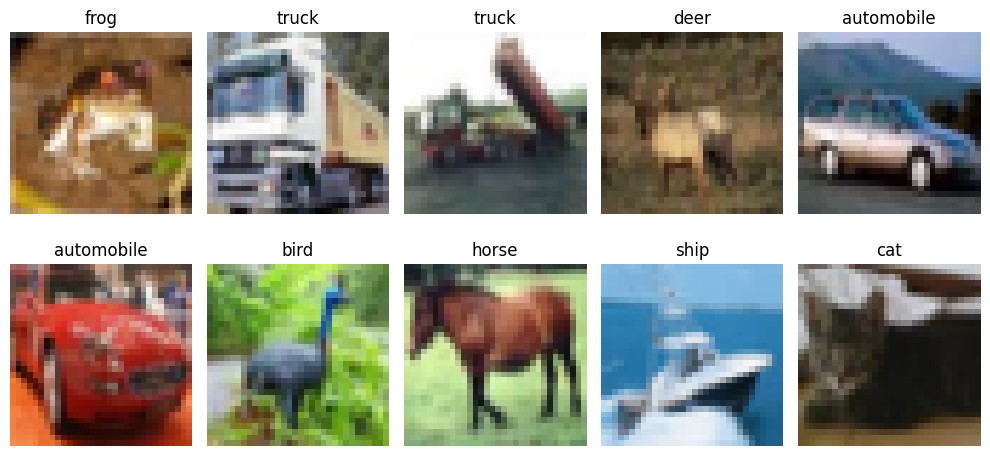

In [147]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [148]:
from sklearn.model_selection import train_test_split

y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# 5. Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=5000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=1000, stratify=y_test, random_state=42
)

scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)
X_test_small_scaled = scaler.transform(X_test_small)

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Reduced classical training shape: (5000, 3072)
Reduced classical test shape: (1000, 3072)


In [149]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

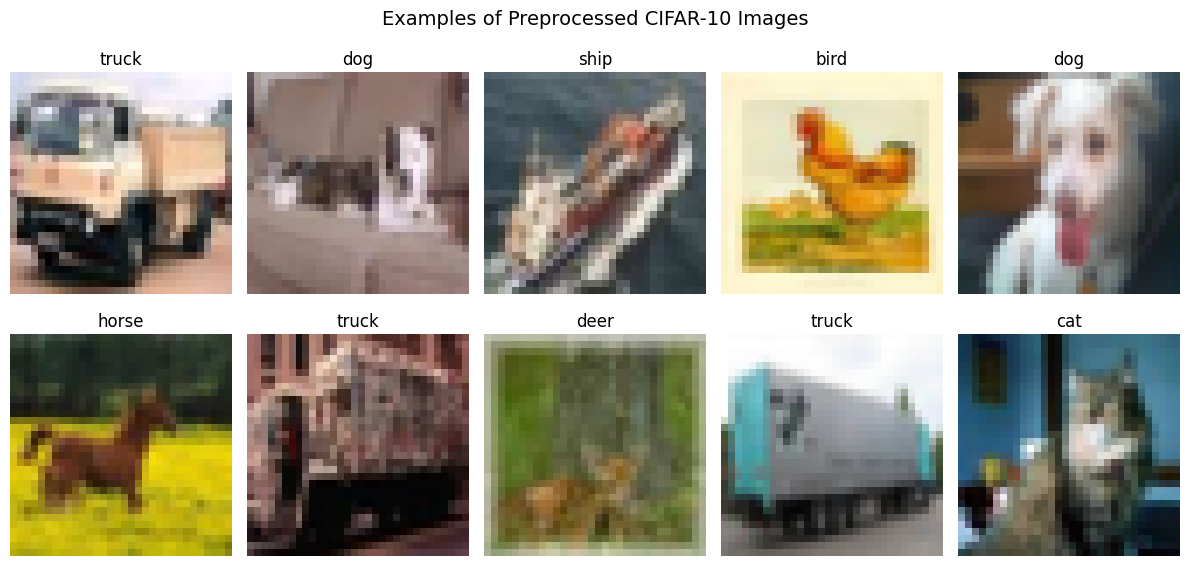

In [ ]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train_flat[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

In [151]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.callbacks import EarlyStopping

# def build_mlp(hidden_units=[512, 256], dropout=0.5, lr=0.001):
#     model = Sequential()
#     model.add(Flatten(input_shape=(32,32,3)))
#     for units in hidden_units:
#         model.add(Dense(units, activation='relu'))
#         model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Try different configurations
# configs = [
#     {'hidden_units':[256,128], 'dropout':0.3},
#     {'hidden_units':[512,256], 'dropout':0.5},
# ]

# for cfg in configs:
#     print(f"Testing config: {cfg}")
#     mlp = build_mlp(hidden_units=cfg['hidden_units'], dropout=cfg['dropout'])
#     mlp.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = mlp.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc)

In [152]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_cnn(num_filters=[32,64], dense_units=128, dropout=0.5):
#     model = Sequential()
#     model.add(Conv2D(num_filters[0], (3,3), activation='relu', input_shape=(32,32,3)))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(num_filters[1], (3,3), activation='relu'))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Configurations to try
# cnn_configs = [
#     {'num_filters':[32,64], 'dense_units':128, 'dropout':0.5},
#     {'num_filters':[64,128], 'dense_units':256, 'dropout':0.3},
# ]

# for cfg in cnn_configs:
#     print(f"Testing config: {cfg}")
#     cnn = build_cnn(**cfg)
#     cnn.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = cnn.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc) 

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [ ]:
# Classical models
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
svm = SVC()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
adb = AdaBoostClassifier(random_state=42, algorithm='SAMME.R')
gb = GradientBoostingClassifier(random_state=42)
bag = BaggingClassifier(random_state=42)
nb = GaussianNB()


### Fully connected neural network

In [154]:
fcnn = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
fcnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Convolutional neural network

In [155]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [156]:
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "Decision Tree": dt,
    "Random Forest": rf,
    "AdaBoost": adb,
    "Gradient Boosting": gb,
    "Bagging": bag,
    "Naive Bayes": nb,
    "Fully Connected NN": fcnn,
    "CNN": cnn
}

print("\n✅ Models created and stored in dictionary:")
for name in models.keys():
    print("-", name)


✅ Models created and stored in dictionary:
- Logistic Regression
- SVM
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- Bagging
- Naive Bayes
- Fully Connected NN
- CNN


## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
tuned_results = {}
best_models = {}

# Define parameter grids
param_grids = {
    "Logistic Regression": {"max_iter": [500, 1000], "C": [0.1, 1.0], "max_iter": [500, 1000]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Decision Tree": {"max_depth": [5,10,20,None], "min_samples_split": [2,5,10]},
    "Random Forest": {"n_estimators": [50, 100], "max_depth": [10, 20, None]},
    "AdaBoost": {"n_estimators":[50, 100], "learning_rate":[0.001, 0.01, 0.1]},
    "Gradient Boosting": {"n_estimators":[50, 100], "learning_rate":[0.001, 0.01, 0.1], "max_depth":[1,3,5]},
    "Bagging": {"n_estimators":[50, 100]},
    "Naive Bayes": {}
}

for name, model in models.items():
    if name not in param_grids:
        continue  # skip neural networks

    print(f"\n🔹 Tuning {name} ...")
    grid = param_grids[name]

    # Use scaled data for Logistic Regression & SVM
    if name in ["Logistic Regression", "SVM"]:
        X_train_fit = X_small_scaled
        X_test_fit = X_test_small_scaled
    else:
        X_train_fit = X_small
        X_test_fit = X_test_small

    if len(grid) == 0:
        # No hyperparameters to tune
        model.fit(X_train_fit, y_small)
        y_pred = model.predict(X_test_fit)
        acc = accuracy_score(y_test_small, y_pred)
        tuned_results[name] = acc
        best_models[name] = model
        print(f"✅ {name}: No tuning. Accuracy = {acc:.4f}")
        continue

    # GridSearchCV
    search = GridSearchCV(model, grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0)
    search.fit(X_train_fit, y_small)
    best_model = search.best_estimator_
    best_acc = accuracy_score(y_test_small, best_model.predict(X_test_fit))
    tuned_results[name] = best_acc
    best_models[name] = best_model
    print(f"✅ {name}: Best Params = {search.best_params_}, Accuracy = {best_acc:.4f}")


🔹 Tuning Logistic Regression ...


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

✅ Logistic Regression: Best Params = {'C': 0.1, 'max_iter': 200}, Accuracy = 0.2820

🔹 Tuning SVM ...
✅ SVM: Best Params = {'C': 10, 'kernel': 'rbf'}, Accuracy = 0.4540

🔹 Tuning Decision Tree ...
✅ Decision Tree: Best Params = {'max_depth': 5, 'min_samples_split': 2}, Accuracy = 0.2710

🔹 Tuning Random Forest ...
✅ Random Forest: Best Params = {'max_depth': 20, 'n_estimators': 100}, Accuracy = 0.4150

🔹 Tuning AdaBoost ...


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

✅ AdaBoost: Best Params = {'learning_rate': 0.1, 'n_estimators': 200}, Accuracy = 0.3360

🔹 Tuning Gradient Boosting ...


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(list(tuned_results.items()), columns=["Model", "Tuned Accuracy"])
print("\n🏁 Hyperparameter Tuning Summary:")
print(results_df)

### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network